Michael Albergo

In [35]:
import numpy as np
import torch
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import torch
from torch.autograd import Variable, grad
from torch.nn.functional import binary_cross_entropy_with_logits as bce

### Learning to generate a samples from a gaussian or beta distribution.


Adapted from an example working with Dr. David Lopez-Paz.

In [36]:
class Perceptron(torch.nn.Module):
    def __init__(self, sizes, final=None):
        super(Perceptron, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
            if i != (len(sizes) - 2):
                layers.append(torch.nn.ReLU())
        if final is not None:
            layers.append(final())
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


# def plot(x, y):
#     real = x.cpu().data.numpy()
#     print real.shape
#     fake = y.cpu().data.numpy()
#     print fake.shape
#     #lims = (x.data.min() - 0.1, x.data.max() + 0.1)
#     xlim = (-3.5, 3.5)
#     plt.figure(figsize=(2, 2))
#     plt.hist(real, label='real', bins=np.arange(-3.5, 3.5, 0.2))
#     plt.hist(fake, alpha=0.25, label='fake', bins=np.arange(-3.5, 3.5, 0.2))
#     plt.axis('on')
#     plt.gca().axes.get_xaxis().set_visible(True)
#     plt.gca().axes.get_yaxis().set_visible(True)
#     plt.xlim(xlim)
#     plt.tight_layout(0, 0, 0)
#     plt.show()


def means_gaussian(std = 1, n_samples = 1000):
    m = torch.Tensor(n_samples, 1)
    return (m.normal_(0,std))

def means_beta(a=0.7, b=0.7, n_samples=1000):
    m = np.random.beta(a=0.7, b = 0.7, size=n_samples)
    return torch.tensor(m).to(device)

# def sample_real(n, shape, std=1.):
#     m = means_gaussian(std, n)
#     return Variable(m, requires_grad=True)

def sample_real(a=0.7, b=0.7, n_samples=1000):
    #m = np.random.beta(a=0.7, b = 0.7, size=n_samples)
    m = np.random.normal(0,1,size=n_samples)
    return torch.tensor(m).type(torch.FloatTensor).to(device).unsqueeze(1).requires_grad_(True)


def sample_noise(bs, d):
    z = torch.rand(bs, d).type(torch.FloatTensor).to(device)
    return z



In [37]:
import os
import datetime
curdir = os.getcwd()
mydir = os.path.join(curdir + "/figs/", 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
#mydir=None
print(mydir)
if mydir != None:
    try:
        os.makedirs(mydir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
            
    with open(mydir + 'NetworkInfo.txt', 'w') as f:
        f.write( 'generator: ' +  str(netG) + "\n")
        f.write('discriminator: ' +  str(netD) + '\n')
        if model == 'GAN-DP':
            f.write('gamma: ' + str(gamma) + '\n')
        #f.write("")
        #f.write('normalization scale: ' +  norm_scale + '\n')
        #f.write('image height/width: ' + str(imageSize) + '\n')
        #f.write('loss function: BCE with Roth Penalty \n')


/Users/michaelalbergo/Documents/Academia/Perimeter/research/figs/2019-01-29_16-42-10/


In [38]:
n_iterations = 2000
n_latent = 1
n_layers = 3
n_hidden = 512
bs = 256
shape = 'beta'
lamD = 10.
extraD = 10
model = 'GAN-DP'
if model == 'WGAN-GP':
    wgan = True
else:
    wgan=False
gamma = 1.0
verbose = True
v_freq = 20
n_samples = 5000
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
    
iteration = 0
real_fwhms = []
fake_fwhms = []
real_means = []
fake_means = []
epochs = []


netD = Perceptron([1] + [n_hidden] * n_layers + [1], final=None).to(device)
netG = Perceptron([n_latent] + [n_hidden] * n_layers + [1]).to(device)
print(netD)
optD = torch.optim.Adam(netD.parameters(), lr=1e-3)
optG = torch.optim.Adam(netG.parameters(), lr=1e-3)

p_real = sample_real(a=0.7, b=0.7, n_samples=n_samples)
p_nois = sample_noise(n_samples, n_latent)
#print p_nois.data.numpy().shape
#print p_real.data.numpy().shape

Perceptron(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [39]:
def objective_wgan(fakeD, realD):
    return fakeD.mean() - realD.mean()


def objective_gan(fakeD, realD):
    labD = torch.cat((torch.ones(fake.size(0), 1) - 1e-3,
                      torch.zeros(real.size(0), 1) + 1e-3))
    return bce(torch.cat((fakeD, realD)), (labD).to(device))

In [40]:

def hist_width_mean(hist_data):

    mean = hist_data.mean()
    std = hist_data.std()
    FWHM = 2.*np.sqrt(2.*np.log(2.))*std

    return FWHM, mean



def plot_all_metrics(real_FWHMs, fake_FWHMs, real_means, fake_means, epochs, n_epochs, save_dir =None, model='GAN'):

    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(4,8), sharey = False, sharex = True)

    ax1.scatter(epochs, real_FWHMs, alpha = 0.75, label = 'real');
    ax1.scatter(epochs, fake_FWHMs, alpha = 0.70, label = 'fake');
    ax1.set_title("FWHMs")
    ax1.set_ylim(1, 4)
    ax1.set_xlim(0,n_epochs)
    #fig.suptitle(str(model) + " Metrics", x=0.5, y = 1.0, fontsize = 13) 
    ax1.text(750, 3.7, model, color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    ax2.scatter(epochs, real_means, alpha = 0.75, label = 'real');
    ax2.scatter(epochs, fake_means, alpha = 0.70, label = 'fake');
    ax2.set_xlabel("Epoch")
    ax2.set_title("Means")
    ax2.set_ylim(-1, 1)
    ax2.set_xlim(0,n_epochs)
    ax1.legend(loc='best')
    ax1.legend(bbox_to_anchor=[1.3, -0.1], loc='center right')


    if save_dir != None:
        FWHMs_Means_comp = "FHWMsMeans_Gaussian_Epoch" + str(len(epochs)) + ".pdf"
        plt.savefig(save_dir + FWHMs_Means_comp, bbox_inches="tight")

    plt.show()

    return


def plot_big(savedir=mydir, iteration = iteration):
    p_nois = sample_noise(n_samples, n_latent)
    outputs = netG(p_nois)
    real_sample = sample_real(a=0.6, b=0.6,n_samples = 10000).cpu().data.numpy()
    #print real_sample.shape
    #print outputs.shape
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.hist(p_real.cpu().data.numpy(), alpha = 0.75, label = "real", bins=np.arange(-3.5,  3.5, 0.2))
    ax.hist(outputs.cpu().data.numpy(), alpha = 0.75, label = "fake", bins=np.arange(-3.5, 3.5, 0.2))
    ax.set_xlim(-4,4)
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")
    ax.legend(loc='upper right')
    ax.set_title( "Gaussian Generation, " + str(model))
    ax.yaxis.tick_left()
    ax.yaxis.set_label_position("left")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.text(-3.8, 355, 'mean: ' + str(round(outputs.cpu().data.numpy().mean(),3)), fontsize = 12, alpha = 0.8, color = 'xkcd:orange')
    plt.text(-3.8, 335, 'std: ' + str(round(outputs.cpu().data.numpy().std(), 3)), fontsize = 12, alpha = 0.8, color = 'xkcd:orange')
    plt.text(-3.8, 290, 'real mean: 0.0', fontsize = 12, alpha = 0.85, color = 'xkcd:blue')
    plt.text(-3.8, 270, 'real std: ' + str(round(real_sample.std(),3)), fontsize = 12, alpha = 0.85, color = 'xkcd:blue')
    plt.tight_layout()
    if savedir != None:
        plt.savefig(savedir + "/GeneratedGaussianSample_LinearReluPerceptronGAN" + str(n_layers) + "Layers_" + str(n_hidden) + 
                    "hiddenPerLayer_size" + str(bs) + "Batch_" + str(iteration) + "Epoch_.png")
    return
#plot_big()
#itera+=1
    
    

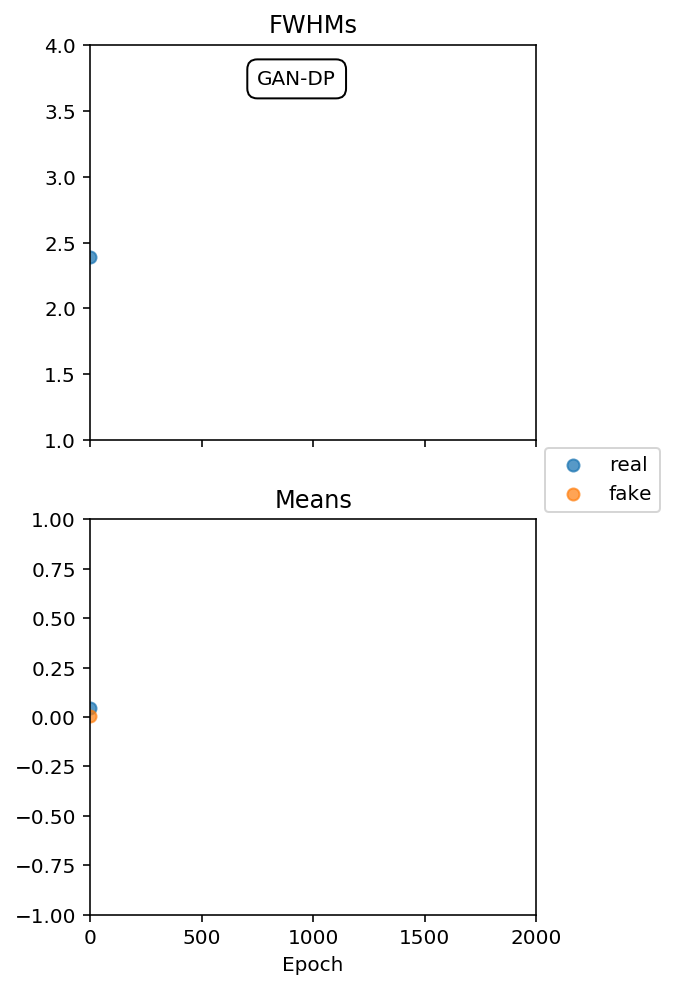

/Users/michaelalbergo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch #1: Generative Loss: -0.508642852306366, Discriminative Loss: 0.508082926273346
Epoch #21: Generative Loss: -0.5050162076950073, Discriminative Loss: 0.5058371424674988


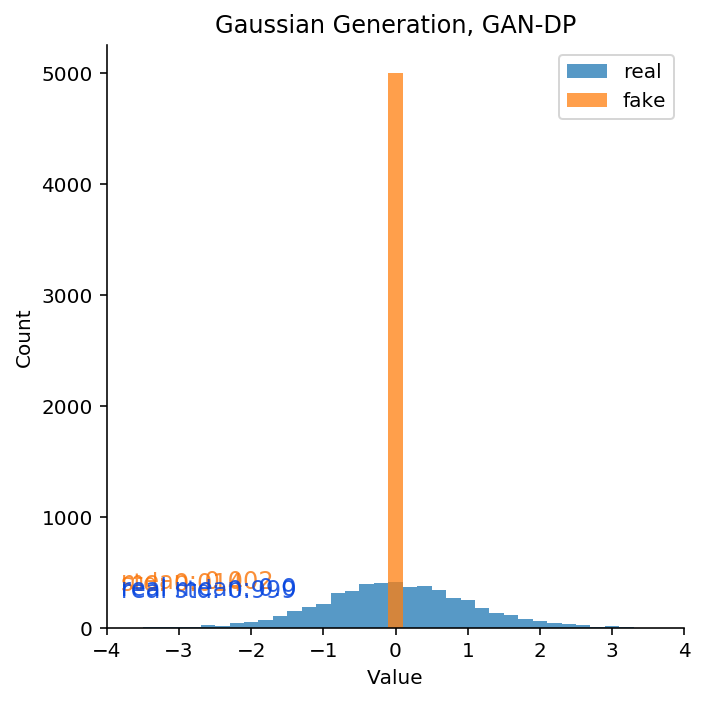

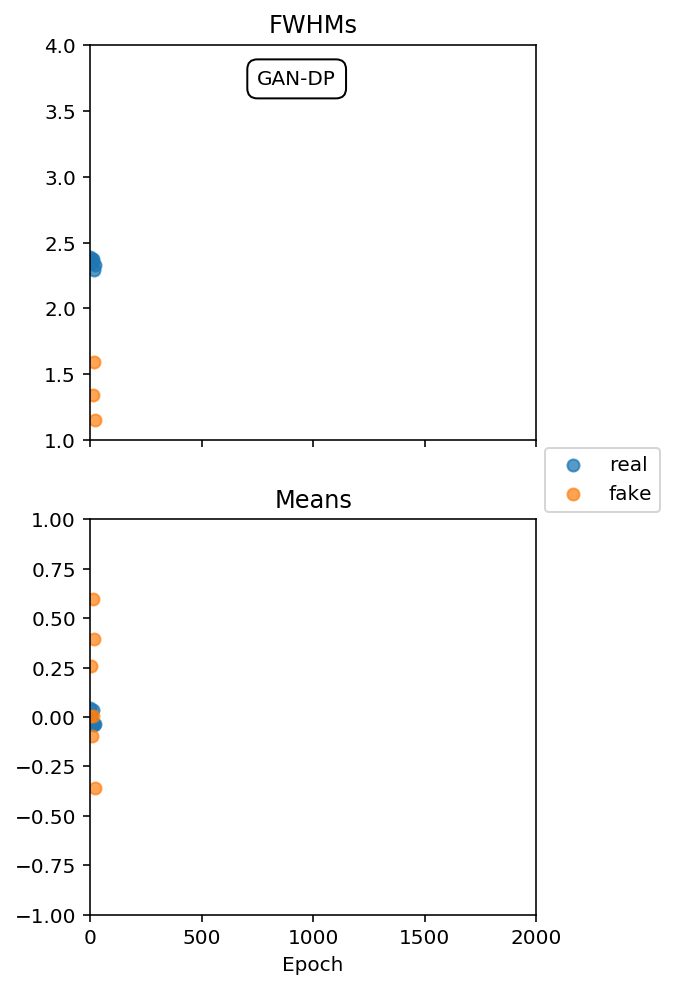

Epoch #41: Generative Loss: -0.5052040815353394, Discriminative Loss: 0.504950761795044


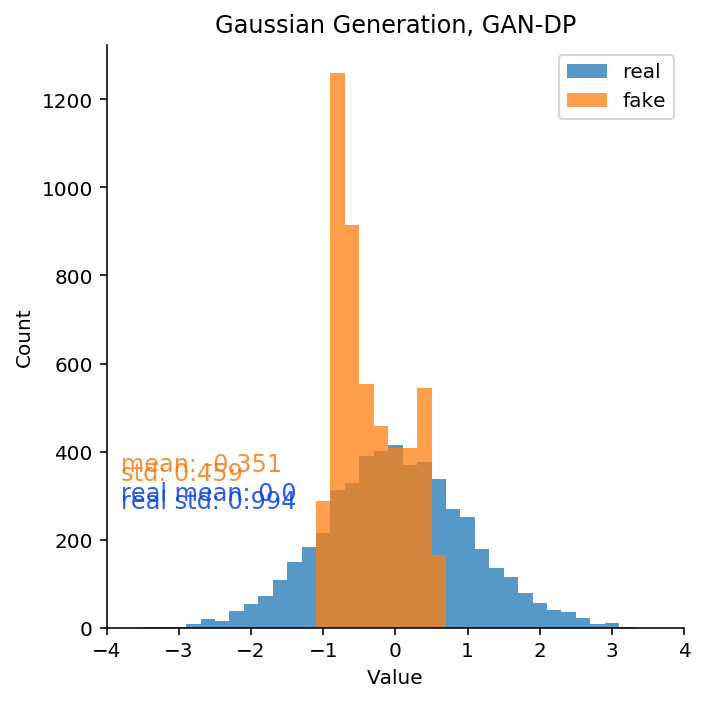

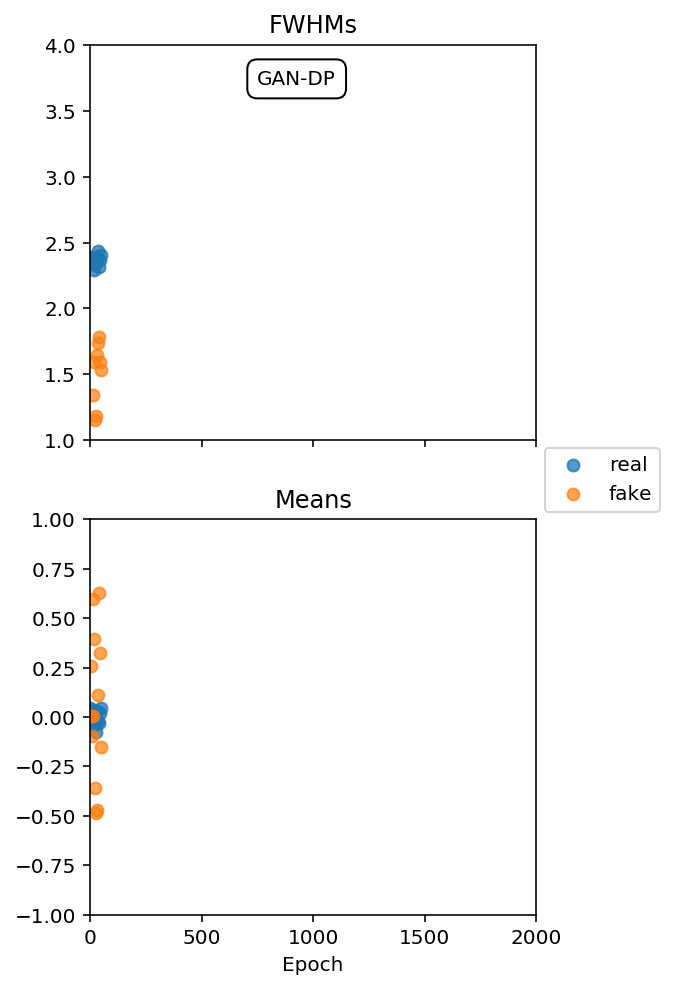

Epoch #61: Generative Loss: -0.5066652894020081, Discriminative Loss: 0.5062681436538696


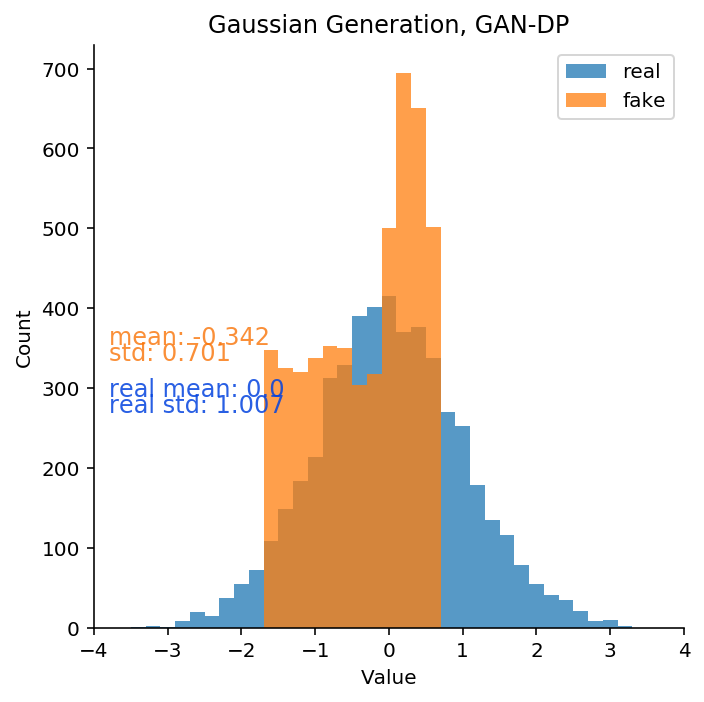

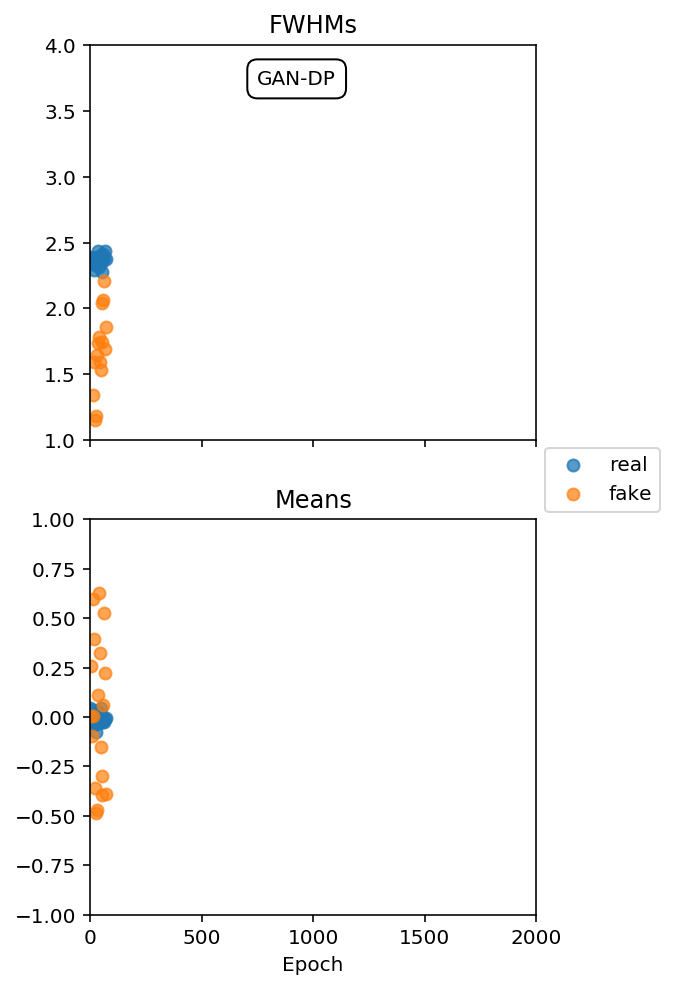

Epoch #81: Generative Loss: -0.5061382055282593, Discriminative Loss: 0.5068175792694092


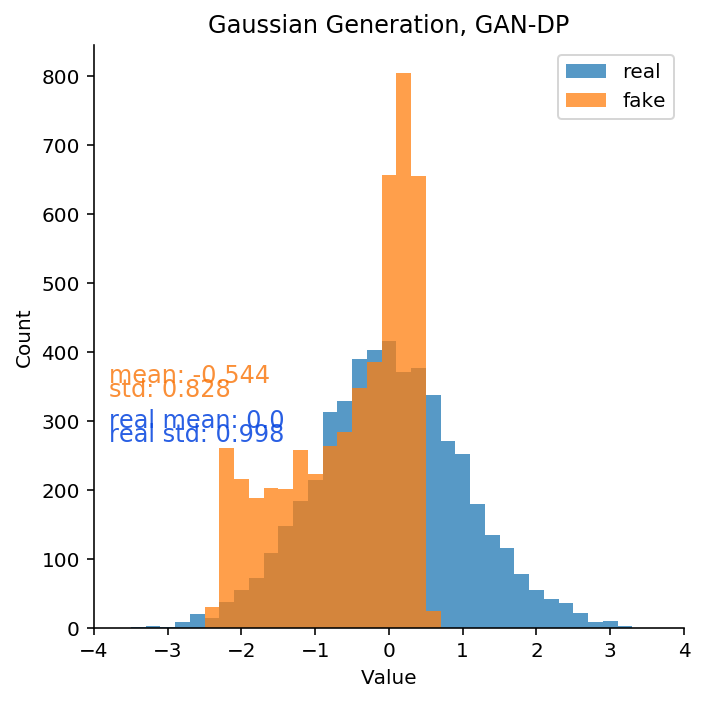

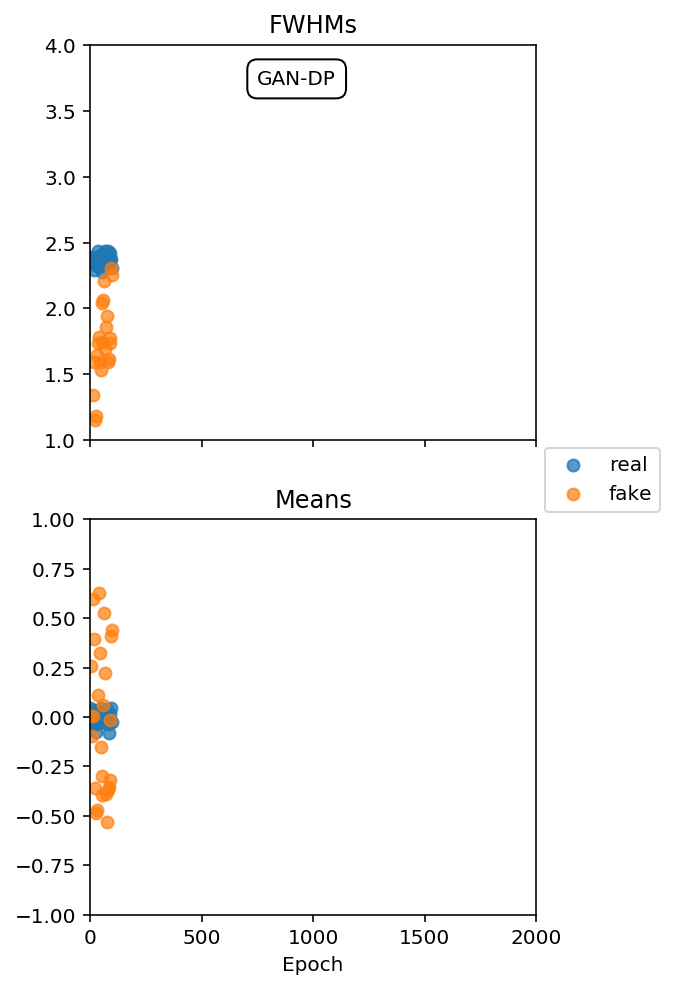

Epoch #101: Generative Loss: -0.5062243938446045, Discriminative Loss: 0.5063220262527466
Epoch #121: Generative Loss: -0.5063468813896179, Discriminative Loss: 0.5062729120254517


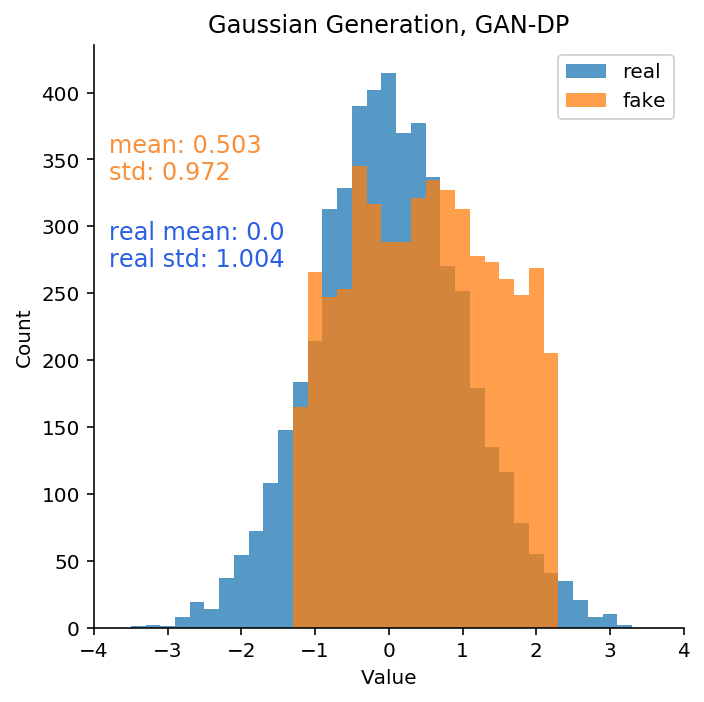

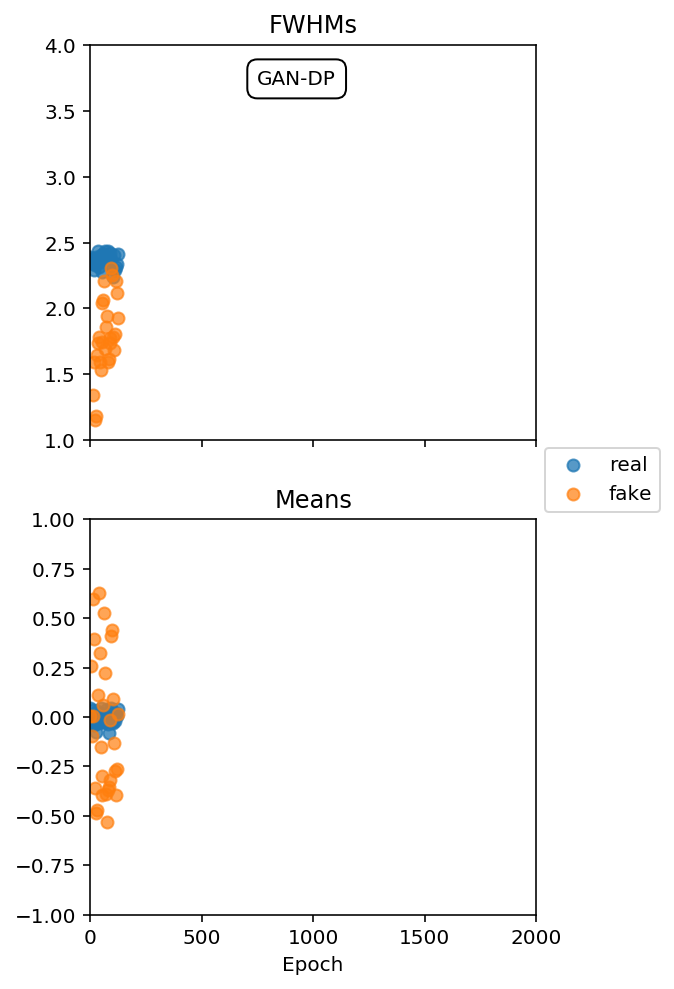

Epoch #141: Generative Loss: -0.5060720443725586, Discriminative Loss: 0.5064141750335693


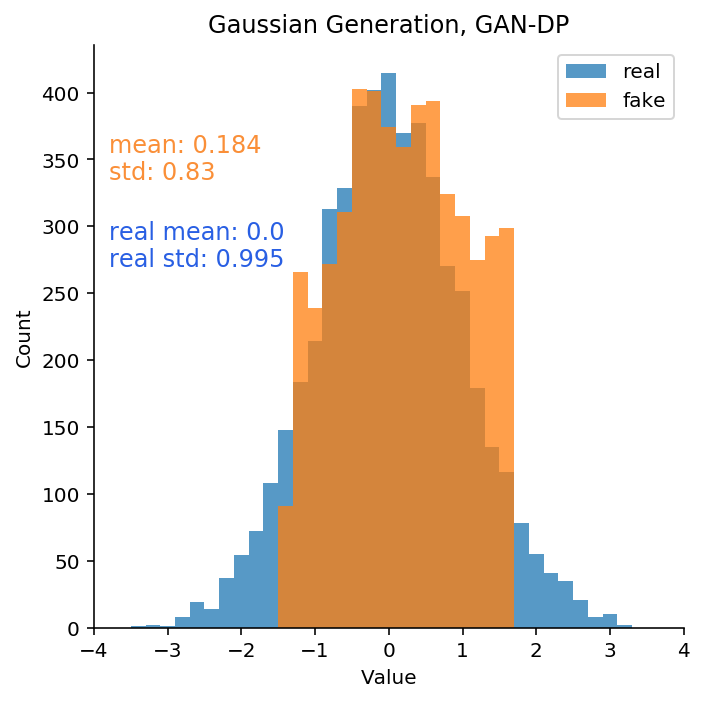

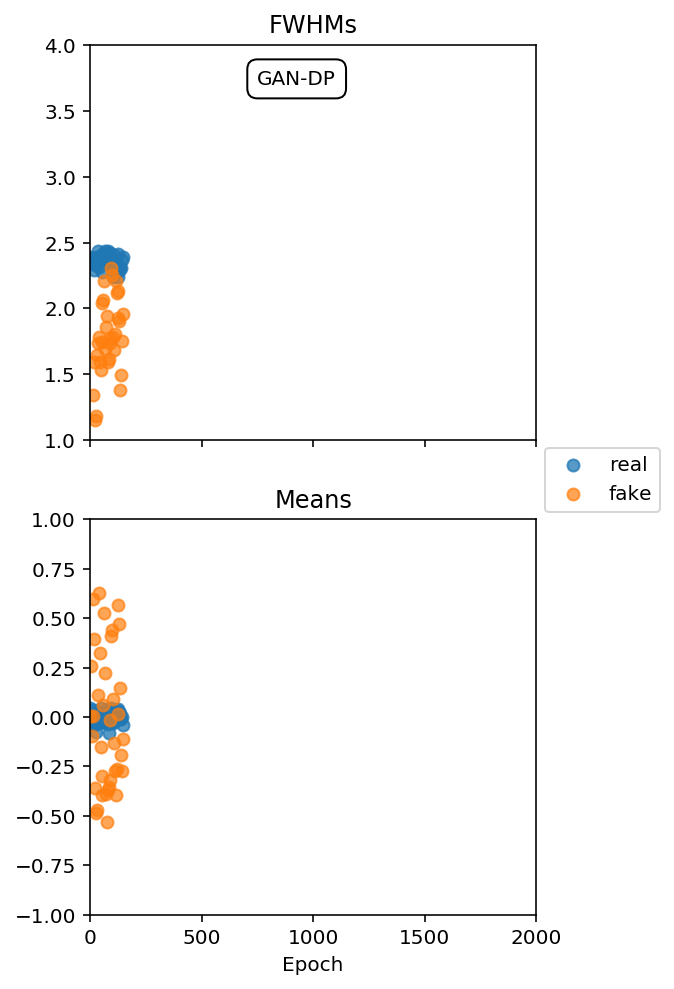

Epoch #161: Generative Loss: -0.5063037276268005, Discriminative Loss: 0.5063149929046631


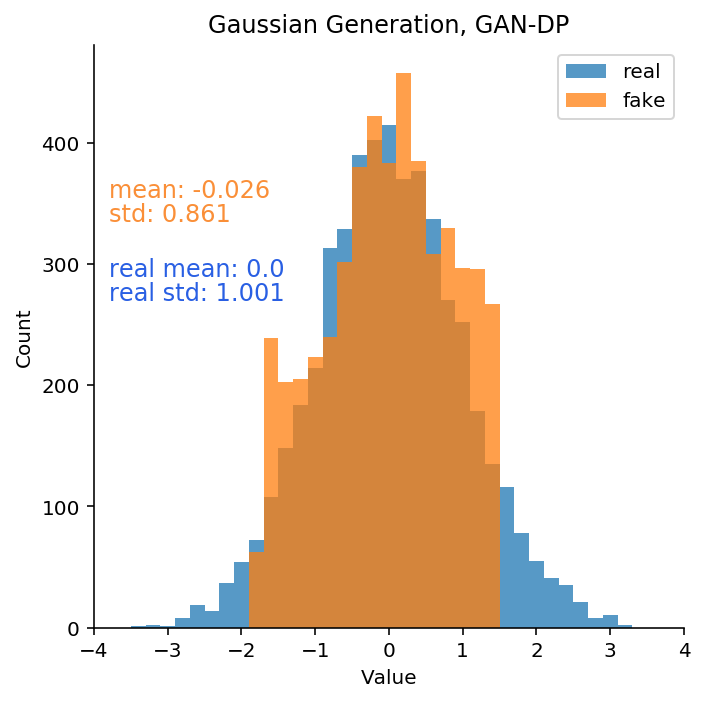

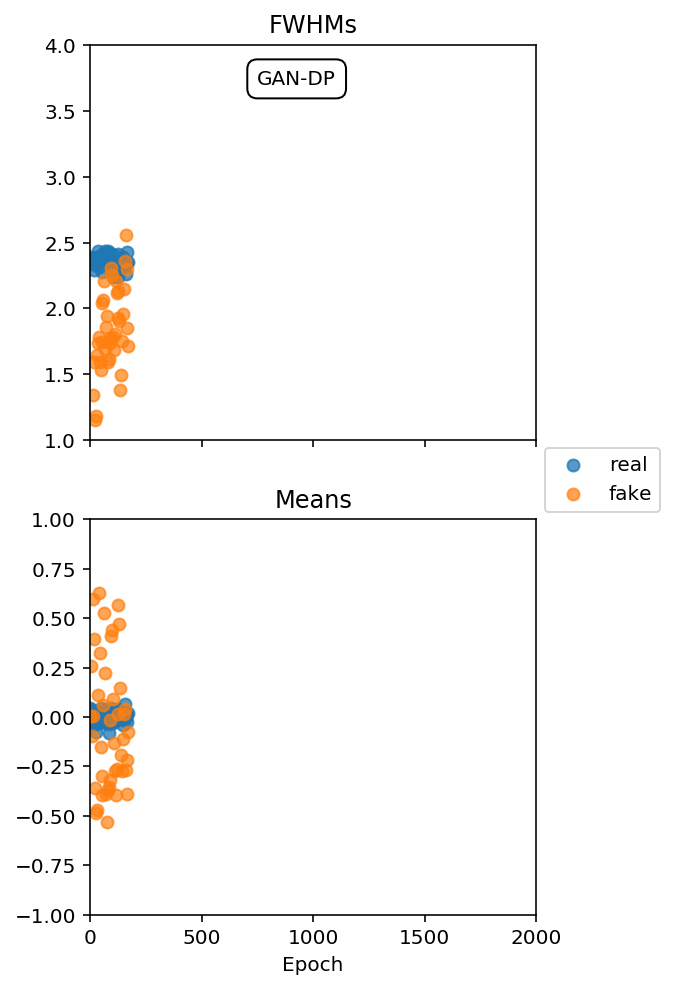

Epoch #181: Generative Loss: -0.5066616535186768, Discriminative Loss: 0.5067113637924194


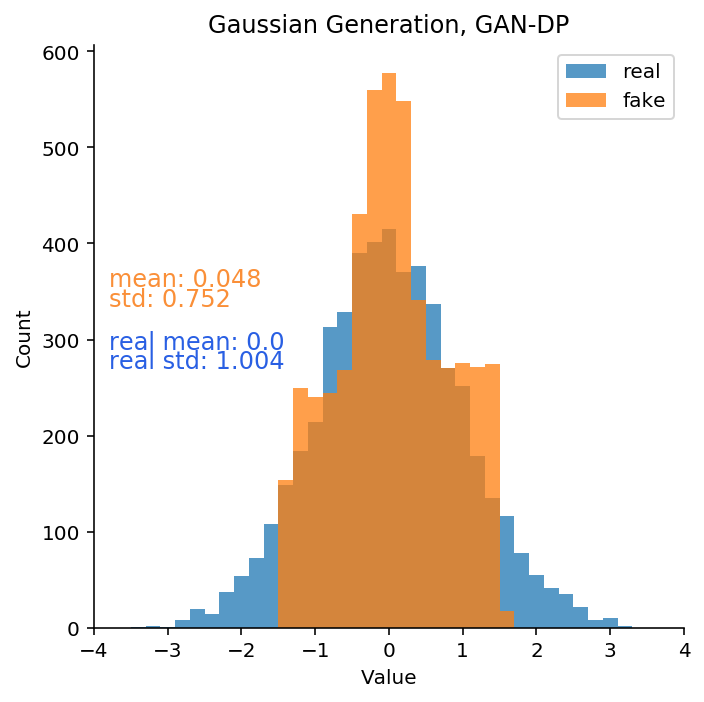

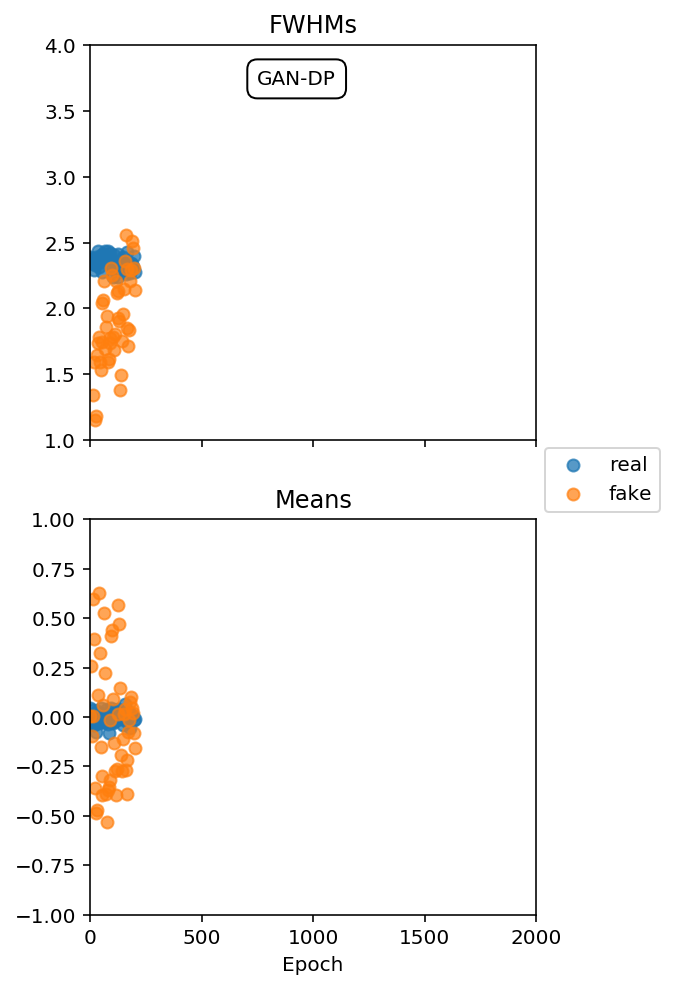

Epoch #201: Generative Loss: -0.5064369440078735, Discriminative Loss: 0.5067301988601685
Epoch #221: Generative Loss: -0.5065963268280029, Discriminative Loss: 0.5063861608505249


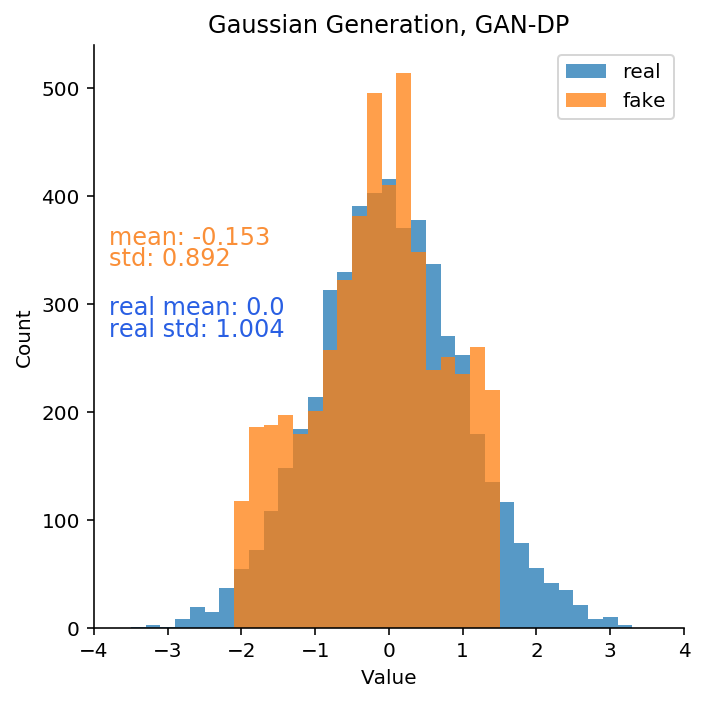

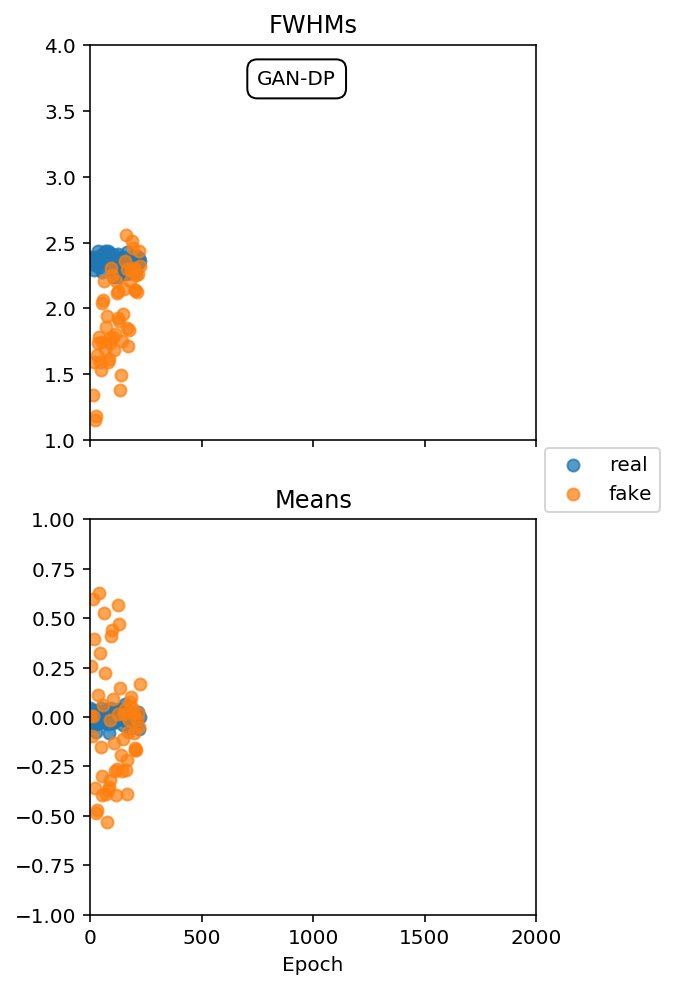

Epoch #241: Generative Loss: -0.5064737796783447, Discriminative Loss: 0.5064741373062134


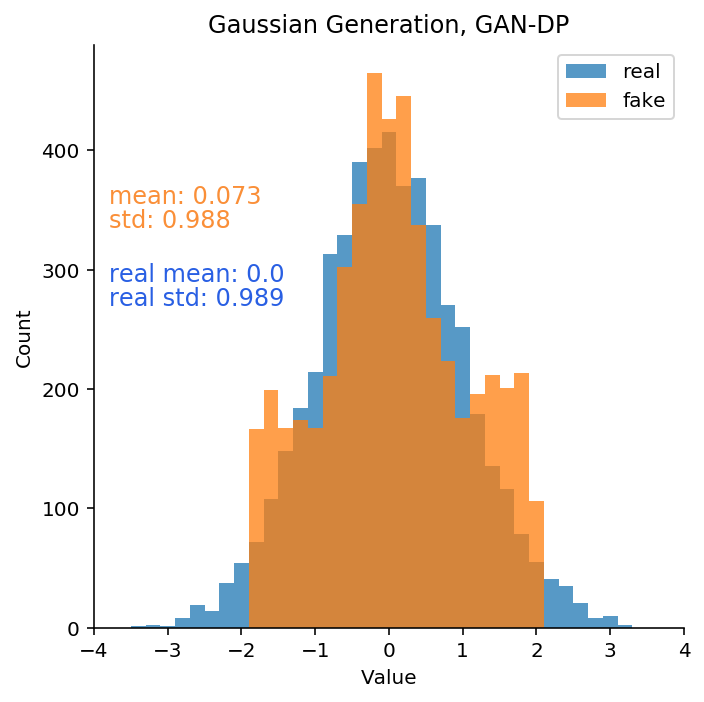

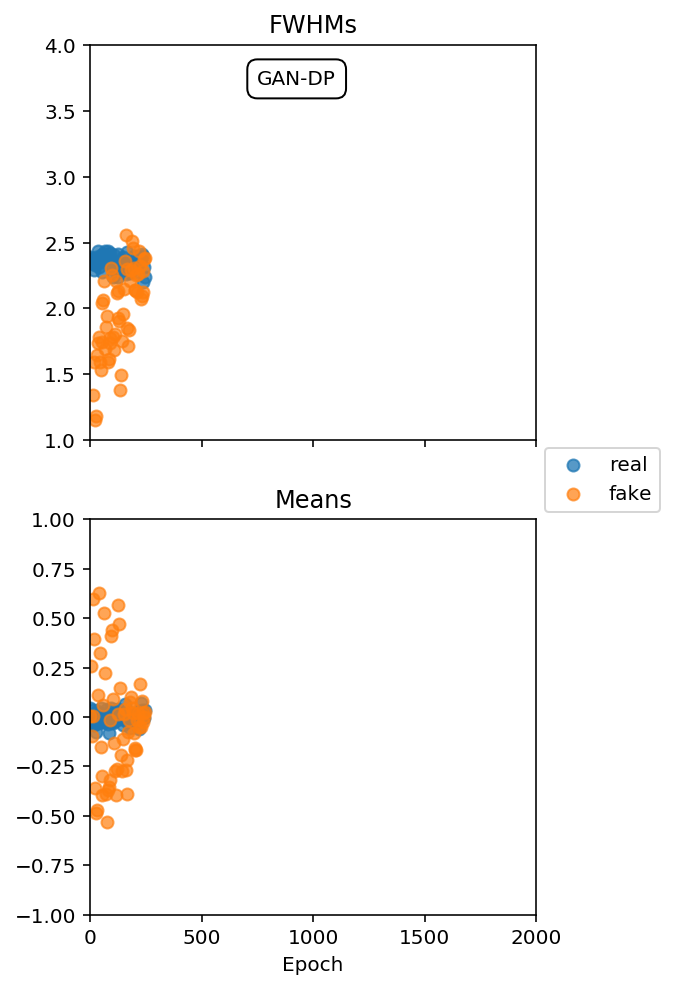

Epoch #261: Generative Loss: -0.5065876245498657, Discriminative Loss: 0.5063555240631104


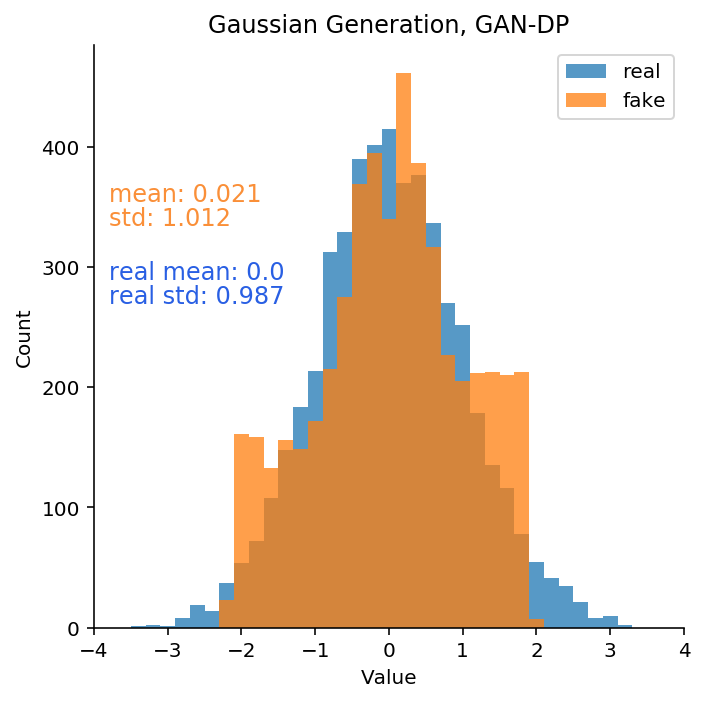

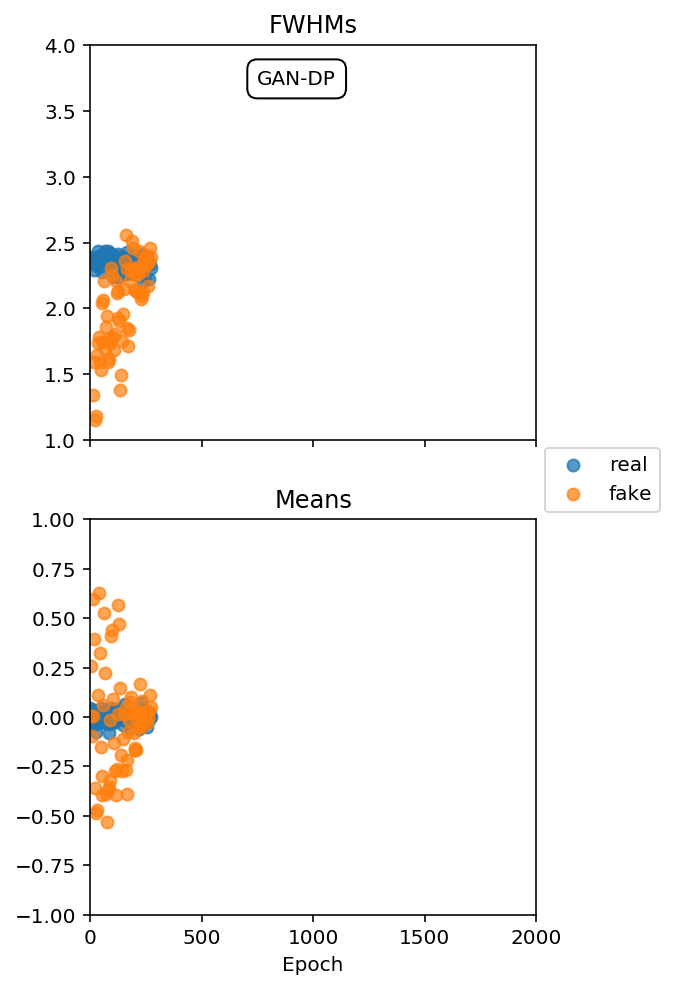

Epoch #281: Generative Loss: -0.506430983543396, Discriminative Loss: 0.5065709948539734


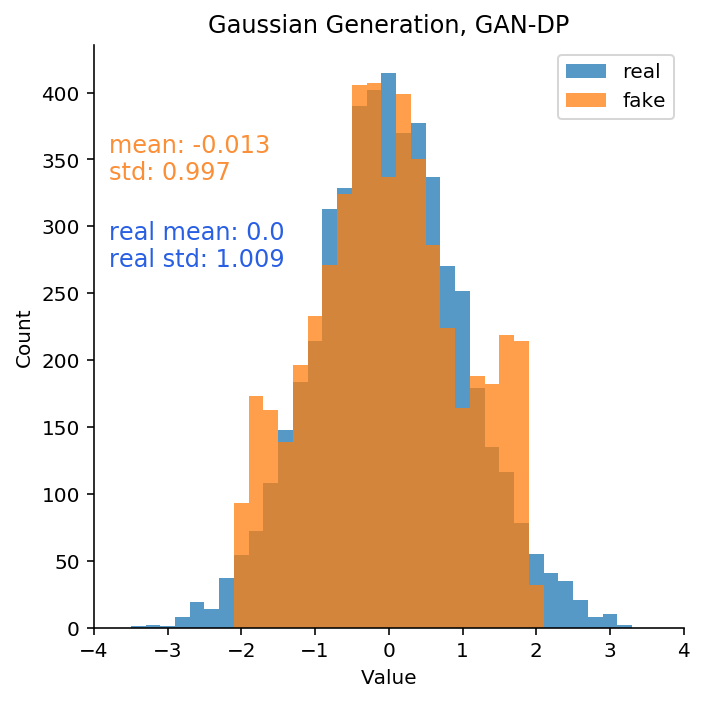

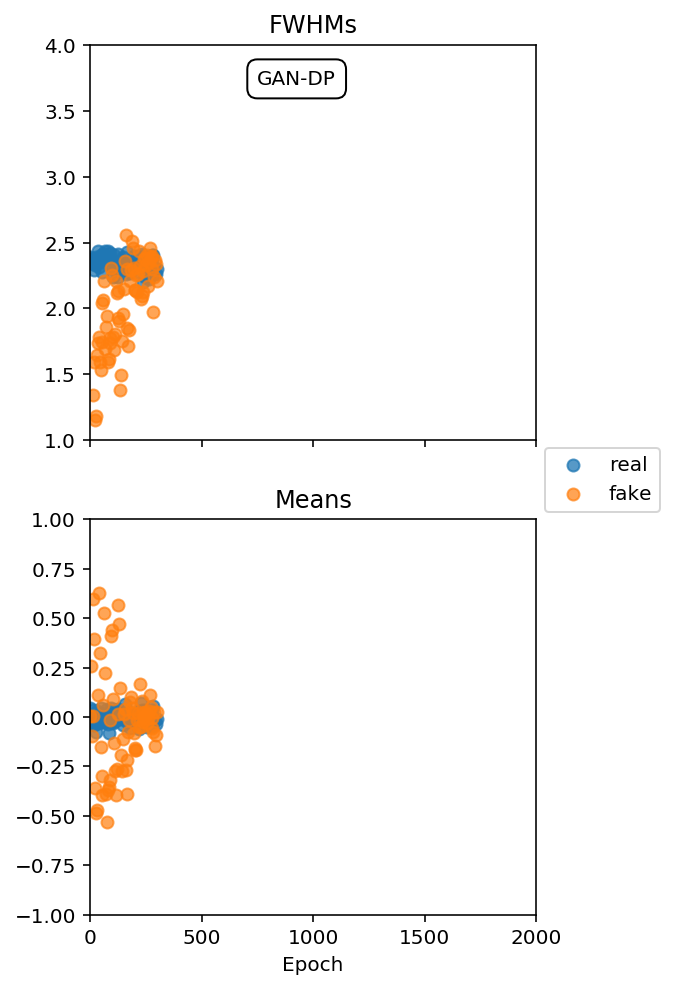

Epoch #301: Generative Loss: -0.506710946559906, Discriminative Loss: 0.5064033269882202
Epoch #321: Generative Loss: -0.5065860152244568, Discriminative Loss: 0.5065406560897827


KeyboardInterrupt: 

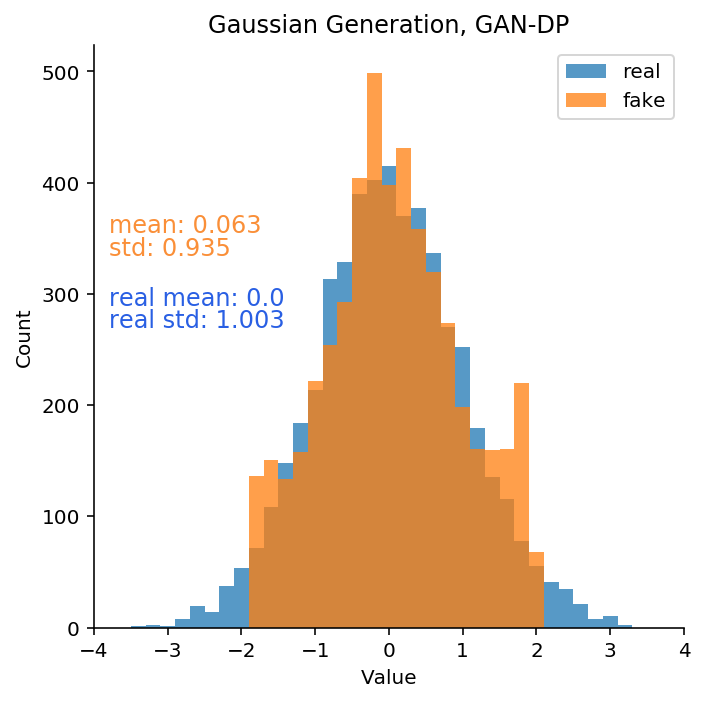

In [41]:




objective = objective_wgan if wgan else objective_gan

iter_range = range(n_iterations)

#print out time information if verbose is True
#if verbose:
#    iter_range = tqdm(iter_range)

real_fwhms = []
fake_fwhms = []
real_means = []
fake_means = []
epochs = []
#gamma= 1.0
for iteration in iter_range:
    if iteration % 4 == 0:
        real = sample_real(bs, shape)
        fake = netG(sample_noise(bs, n_latent))
        fake_FWHM, fake_mean = hist_width_mean(fake.cpu().data.numpy())
        real_FWHM, real_mean = hist_width_mean(real.cpu().data.numpy())
        real_fwhms.append(real_FWHM)
        fake_fwhms.append(fake_FWHM)
        real_means.append(real_mean)
        fake_means.append(fake_mean)
        epochs.append(iteration)

    
    if iteration % 20 == 0:
        plot_all_metrics(real_fwhms, fake_fwhms, real_means, fake_means, 
                        epochs, n_iterations, save_dir = mydir, model=model)
        plot_big(savedir=mydir, iteration=iteration)
    
    for extra in range(extraD):
        
        # create a sample of real data in the shape of interest
        netD.zero_grad()
        real = sample_real(bs, shape)
        fake = netG(sample_noise(bs, n_latent))
        data = torch.cat((fake, real), 0)
        

        optD.zero_grad()
        d_real = netD(real)
        d_fake = netD(fake)
        lossD = objective(d_real, d_fake)
        if model == 'WGAN-GP':
            #improved training of wasserstein gans
            gradD = grad(lossD * bs, fake, create_graph=True)[0]
            reguD = gradD.norm(2, 1).clamp(1).mean()
            (lossD + lamD * reguD).backward()
        
        elif model == 'GAN-DP':
            # Roth penalty
            penalty = grad(d_real.sum(), real, create_graph=True)[0].view(-1,1).norm(2,1).pow(2).mean()
            (lossD + (gamma/2) * penalty).backward()
        
        optD.step()

    real = sample_real(bs, shape)
    fake = netG(sample_noise(bs, n_latent))

    optG.zero_grad()
    lossG = - objective(netD(real), netD(fake))
    (lossG).backward()
    optG.step()
    


    if (iteration % v_freq) == 0:
        #print "Iteration: " iteration, "Discriminative Loss: " lossD.data[0], 
              #"Generative Loss: " lossG.data[0], reguD.data[0]
        print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(iteration + 1, lossG.data[0], lossD.data[0]))



#Gloss, Dloss = train(netG, netD, shape = shape, wgan=False, verbose = False)



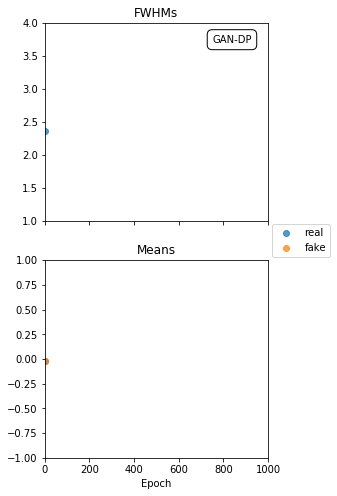

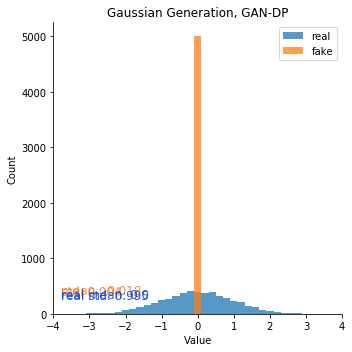

In [10]:
plot_all_metrics(real_fwhms, fake_fwhms, real_means, fake_means, 
                        epochs, n_iterations, save_dir = mydir, model=model)
itera = 1
def plot_big(savedir=mydir,iteration = iteration):
    p_nois = sample_noise(n_samples, n_latent)
    outputs = netG(p_nois)
    real_sample = sample_real(a=0.6, b=0.6,n_samples = 10000).cpu().data.numpy()
    #print real_sample.shape
    #print outputs.shape
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.hist(p_real.cpu().data.numpy(), alpha = 0.75, label = "real", bins=np.arange(-3.5,  3.5, 0.2))
    ax.hist(outputs.cpu().data.numpy(), alpha = 0.75, label = "fake", bins=np.arange(-3.5, 3.5, 0.2))
    ax.set_xlim(-4,4)
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")
    ax.legend(loc='upper right')
    ax.set_title( "Gaussian Generation, " + str(model))
    ax.yaxis.tick_left()
    ax.yaxis.set_label_position("left")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.text(-3.8, 355, 'mean: ' + str(round(outputs.cpu().data.numpy().mean(),3)), fontsize = 12, alpha = 0.8, color = 'xkcd:orange')
    plt.text(-3.8, 335, 'std: ' + str(round(outputs.cpu().data.numpy().std(), 3)), fontsize = 12, alpha = 0.8, color = 'xkcd:orange')
    plt.text(-3.8, 290, 'real mean: 0.0', fontsize = 12, alpha = 0.85, color = 'xkcd:blue')
    plt.text(-3.8, 270, 'real std: ' + str(round(real_sample.std(),3)), fontsize = 12, alpha = 0.85, color = 'xkcd:blue')
    plt.tight_layout()
    if savedir != None:
        plt.savefig(savedir + "/GeneratedGaussianSample_LinearReluPerceptronGAN" + str(n_layers) + "Layers_" + str(n_hidden) + 
                    "hiddenPerLayer_size" + str(bs) + "Batch_" + str(n_iterations) + "Epochs_.pdf")
    return
plot_big()
itera+=1
    
    

In [ ]:
plot(outputs, sample_real(1000,shape))

In [153]:
p_nois = sample_noise(10000, n_latent)
outputs = netG(p_nois).cpu().data.numpy()
real_sample = sample_real(a=0.6, b=0.6,n_samples = 10000).cpu().data.numpy()

In [154]:
outputs_histo, obins = np.histogram(outputs, bins = 20) 
real_sample_histo, sbins = np.histogram(real_sample, bins = 20)

In [155]:
gen_probs = outputs_histo.astype(float) / outputs_histo.sum()
real_probs = real_sample_histo.astype(float) / real_sample_histo.sum()

In [156]:
from scipy.stats import entropy

In [157]:
entropy(gen_probs, real_probs)

0.7793978637340008

In [251]:
from scipy.stats import entropy

entro = 0
for i in range(100):
    p_nois = sample_noise(10000, n_latent)
    outputs = netG(p_nois).cpu().data.numpy()
    real_sample = sample_real(a=0.6, b=0.6,n_samples = 10000).cpu().data.numpy()
    outputs_histo, obins = np.histogram(outputs, bins = 20) 
    real_sample_histo, sbins = np.histogram(real_sample, bins = 20)
    gen_probs = (outputs_histo.astype(float) / outputs_histo.sum()) + .00001
    real_probs = (real_sample_histo.astype(float) / real_sample_histo.sum()) + .00001
    entro += entropy(gen_probs, real_probs)
    
entro = entro / 100
print entro

0.5834316483087416
